# installation of libraries and packages

In [5]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 44.7 MB/s eta 0:00:00


In [6]:
pip install datasets

#imports from different libraries


In [33]:
import os
import torch
from datasets import load_dataset,Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

from sklearn.model_selection import train_test_split

import pandas as pd

import re


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#hugging face login

In [2]:
directory = '/content/drive/My Drive/my_finetuned_model.h5_v2/'

In [10]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# loading initial dataset from huggingface and making a dataframe


In [35]:
# Define the dataset ID or name
dataset_id = "iamtarun/code_instructions_120k_alpaca"

# Load the dataset
dataset = load_dataset(dataset_id)

# Preview the data
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/121959 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'prompt'],
        num_rows: 121959
    })
})


In [36]:
dataset = dataset['train']
# Convert the dataset to a Pandas DataFrame
df = dataset.to_pandas()

# Display the first few rows of the DataFrame
df.head()

,instruction,input,output,prompt
0,Create a function to calculate the sum of a se...,"[1, 2, 3, 4, 5]",# Python code\ndef sum_sequence(sequence):\n ...,Below is an instruction that describes a task....
1,Develop a function that will add two strings,"str1 = ""Hello ""\nstr2 = ""world""","def add_strings(str1, str2):\n """"""This func...",Below is an instruction that describes a task....
2,Design a data structure in C++ to store inform...,,#include <map>\n#include <string>\n\nclass Gro...,Below is an instruction that describes a task....
3,Implement a sorting algorithm to sort a given ...,"[3, 1, 4, 5, 9, 0]",def bubble_sort(arr):\n n = len(arr)\n \n ...,Below is an instruction that describes a task....
4,Design a Swift application for tracking expens...,Not applicable,import UIKit\n\nclass ExpenseViewController: U...,Below is an instruction that describes a task....


cleaning data for model training

In [37]:
df.drop(columns=['input'], inplace=True)
df.drop(columns=['output'], inplace=True)

In [38]:
df.head()

,instruction,prompt
0,Create a function to calculate the sum of a se...,Below is an instruction that describes a task....
1,Develop a function that will add two strings,Below is an instruction that describes a task....
2,Design a data structure in C++ to store inform...,Below is an instruction that describes a task....
3,Implement a sorting algorithm to sort a given ...,Below is an instruction that describes a task....
4,Design a Swift application for tracking expens...,Below is an instruction that describes a task....


In [39]:
# Remove newline characters (\n) from the 'output' column
# df['prompt'] = df['prompt'].str.replace("\n", "")

# Remove leading and trailing whitespaces from the 'output' column
df['prompt'] = df['prompt'].str.strip()

# Display the first few rows of the updated DataFrame
df.head()

,instruction,prompt
0,Create a function to calculate the sum of a se...,Below is an instruction that describes a task....
1,Develop a function that will add two strings,Below is an instruction that describes a task....
2,Design a data structure in C++ to store inform...,Below is an instruction that describes a task....
3,Implement a sorting algorithm to sort a given ...,Below is an instruction that describes a task....
4,Design a Swift application for tracking expens...,Below is an instruction that describes a task....


## slicing original dataset to get training and testing datasets

In [40]:
train_df = df.sample(n=600, random_state=42)

remaining_df = df.drop(train_df.index)

test_df = remaining_df.sample(n=75, random_state=42)




# Define a function to create a text-to-text dataset
def create_text_to_text_dataset(data_df):
    dataset = []
    for _, row in data_df.iterrows():
        source = row['instruction']
        target = row['prompt']
        dataset.append((source, target))
    return dataset

# Create text-to-text datasets
train_dataset = create_text_to_text_dataset(train_df)
# val_dataset = create_text_to_text_dataset(val_df)
test_dataset = create_text_to_text_dataset(test_df)

print("Number of rows in train_df:", len(train_dataset))
print("Number of rows in test_df:", len(test_dataset))
print("column names:" , df.columns)

Number of rows in train_df: 600
Number of rows in test_df: 75
column names: Index(['instruction', 'prompt'], dtype='object')


In [41]:
test_df.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/initial_testing_dataset.csv',index=False)

In [ ]:
train_df.head()

,instruction,prompt
110380,Develop an AI-assisted program for optimising ...,Below is an instruction that describes a task....
90512,Design a program to multiply all elements of a...,Below is an instruction that describes a task....
120999,Design an algorithm in Python to check if two ...,Below is an instruction that describes a task....
108276,Create a function in Python that given a strin...,Below is an instruction that describes a task....
79122,Create a Python function clamp that takes a nu...,Below is an instruction that describes a task....


pushing the dataset on drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test_df.to_csv(directory + 'testing_dataset.csv',index = False)

In [ ]:
train_df.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/merged_initial_dataset.csv',index=False)

## Transforming the dataset:
 making the dataset in a format which is compatible for the model training

In [ ]:
SYSTEM_MESSAGE = "Given a puzzle-like code question, provide a well-reasoned, step-by-step Python solution."

def transform_dataset_format(df):
    """Transform the dataframe into a specified format that directly suits the tokenization process."""

    # Define a function that formats each row into the desired text structure
    def transform(row):
        user_text = row["instruction"]
        assistant_text = row["prompt"]

        # Construct the combined text format as a single string
        formatted_text = (
            f"<s>[INST] <</SYS>>\n{SYSTEM_MESSAGE.strip()}\n<</SYS>>\n\n"
            f"{user_text} [/INST] {assistant_text} </s>"
        )
        return formatted_text

    # Apply the transform function across the DataFrame, ensuring output is a Series (not a DataFrame of dicts)
    transformed_series = df.apply(transform, axis=1)

    # Convert the Series back to DataFrame with a proper column name for compatibility
    transformed_df = transformed_series.to_frame(name="text")

    return transformed_df


# initialization and assignment of variables which are later used

In [7]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# Fine-tuned model name
new_model = "Llama-2-python-Afnan_B"
model_C = "Llama-2-python-Afnan_C"
model_D = "Llama-2-python-Afnan_D"


################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [8]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

gc.collect()
gc.collect()

0

#Transforming dataset for model training

In [ ]:
transformed_data1 = transform_dataset_format(train_df)
transformed_data2 = transform_dataset_format(test_df)

In [ ]:
transformed_data1.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/merged__dataset_1.csv',index=False)

In [ ]:
training_data = Dataset.from_pandas(transformed_data1)
testing_data = Dataset.from_pandas(transformed_data2)

In [ ]:
print(training_data.shape)

(600, 2)


In [ ]:
training_data.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/merged__dataset.csv',index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

558871

# Loading Model A and finetuning it to get Model B

In [ ]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
OriginalModel = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
OriginalModel.config.use_cache = False
OriginalModel.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=OriginalModel,
    train_dataset=training_data,
    eval_dataset=testing_data,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,1.141200
50,0.557200
75,0.448600
100,0.441200
125,0.440500
150,0.401200


TrainOutput(global_step=150, training_loss=0.571642500559489, metrics={'train_runtime': 637.9029, 'train_samples_per_second': 0.941, 'train_steps_per_second': 0.235, 'total_flos': 3554092806635520.0, 'train_loss': 0.571642500559489, 'epoch': 1.0})

In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)

In [ ]:
trainer.model.save_pretrained('/content/drive/My Drive/my_finetuned_model.h5_v2')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
finetunedModel = PeftModel.from_pretrained(base_model, '/content/drive/My Drive/my_finetuned_model.h5_v2')
finetunedModel = finetunedModel.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [ ]:
finetunedModel = "ScHemer34/finetuned-Llama2-code-generation"
tokenizer = "ScHemer34/finetuned-Llama2-code-generation"

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "add 2 numbers"
pipe = pipeline(task="text-generation", model=OriginalModel, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

NameError: name 'OriginalModel' is not defined

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "how to add 2 numbers python"
pipe = pipeline(task="text-generation", model=finetunedModel, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s>[INST] how to add 2 numbers python [/INST]  To add two numbers in Python, you can use the `+` operator.

Here is an example:
```
a = 5
b = 10

result = a + b

print(result) # Output: 15
```
Alternatively, you can use the `sum()` function to add a list of numbers.
```
a = [5, 10]

result = sum(a)

print(result) # Output: 15
```
You can also use the `+=` operator to add two numbers and assign the result to a variable.
```
a = 5
b = 10

a += b

print(a) # Output: 15
```
You can also use the `add()` method to add two numbers and assign the result to


In [ ]:
print(finetunedModel)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNo

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)
# prompt_suffix=" provide a brief solution"

# Run text generation pipeline with our next model
prompt = "How can I use Python’s asyncio to perform three web requests concurrently and handle their responses?"
pipe = pipeline(task="text-generation", model=finetunedModel, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] How can I use Python’s asyncio to perform three web requests concurrently and handle their responses? [/INST]  You can use Python's `asyncio` module to perform multiple web requests concurrently and handle their responses. Here is an example of how you can do this:
```
import asyncio

async def fetch_data(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            return await response.json()

async def process_data(data):
    print(data)

async def main():
    urls = ['https://example.com/data1', 'https://example.com/data2', 'https://example.com/data3']
    tasks = [fetch_data(url) for url in urls]
    results = await asyncio.g


In [ ]:
finetunedModel.push_to_hub("ScHemer34/finetuned-Llama2-code-generation", check_pr=True)

tokenizer.push_to_hub("ScHemer34/finetuned-Llama2-code-generation",check_pr=True)

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ScHemer34/finetuned-Llama2-code-generation/commit/f7b0fed6fed931d68a2c54574293fd03f1453be9', commit_message='Upload tokenizer', commit_description='', oid='f7b0fed6fed931d68a2c54574293fd03f1453be9', pr_url=None, pr_revision=None, pr_num=None)

# Synthesizing Dataset Using AWS Model



In [ ]:
API_KEY = "029F85B48F4241819E2C6AF89099607C"

import requests
import json

def llama_generate(prompt,
                   api_token,
                   max_gen_len = 512,
                   temperature = 0.5,
                   top_p =0.9):
  url = 'https://6xtdhvodk2.execute-api.us-west-2.amazonaws.com/dsa_llm/generate'
  body = {
    "prompt": prompt,
    "max_gen_len": max_gen_len,
    "temperature": temperature,
    "top_p": top_p,
    "api_token": api_token
  }
  res = requests.post(url,  json = body)
  return  json.loads(res.text)["body"]["generation"]

In [ ]:
def get_prompt(system, instruction):
    p = f"""
    [INST]
    <<SYS>>
    {system}
    <</SYS>>
    {instruction}
    [/INST]
    """
    return p

In [ ]:
def generate(prompt, sample=False):
    # tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids.cuda()
    # generate the model output with model.generate
    output = finetunedModel.generate(inputs=input_ids, do_sample=sample, temperature=0.7, top_p=0.3, max_new_tokens=512)
    # the length of the input
    start_index = input_ids.shape[-1]
    # model.generate returns the prompt itself, we use start_index to ignore it
    text = tokenizer.decode(output[0][start_index:], skip_special_tokens=True)
    return text

In [ ]:
prompt = get_prompt(
    system="You are the poet of the century.",
    instruction="""Write a Poem about the Data Science For Social Good Group and Their Teaching Assistant Islam Who Helps Teach LLMs"""
    )
print(llama_generate(prompt,API_KEY))

 In this age of data, we find ourselves lost
In a sea of numbers, with no shore to boast
But fear not, dear reader, for there's hope to be found
In the Data Science for Social Good group, profound

Their mission, to use data for the greater good
To uncover truths, that the world may withstand
Their work, a beacon of light in the darkest night
A shining star, that guides us to what's right

And at the helm, a teaching assistant true
Islam, a name that means peace, and peace they do
With patience and kindness, they guide the way
Through the complex world of LLMs, day by day

Their students, a diverse group, from far and wide
With passion and drive, they come to abide
In the art of data science, they seek to excel
And with Islam's help, they'll surely do well

With lectures and labs, they learn and grow
Their knowledge and skills, they begin to show
From data visualization, to machine learning's might
They master it all, with Islam's guidance bright

But it's not just about the science, y

In [ ]:
topics = [
    "Metaprogramming in Python",
    "Concurrency with asyncio",
    "Functional Programming in Python",
    "Asynchronous I/O",
    "Python Design Patterns",
    "Python Data Science Libraries",
    "Building RESTful APIs with Flask",
    "Data Serialization (JSON, Pickle)",
    "Creating Custom Decorators",
    "Data Modeling with SQLAlchemy",
    "Web Scraping with BeautifulSoup",
    "Working with XML in Python",
    "Parallel Programming with multiprocessing",
    "Machine Learning Pipelines",
    "Natural Language Processing (NLP) with NLTK",
    "Creating a Chatbot with Python",
    "Reinforcement Learning with OpenAI Gym",
    "Distributed Computing with PySpark",
    "Geospatial Analysis with GeoPandas",
    "Cryptography in Python",
    "Implementing Design Patterns in Python",
    "Testing REST APIs with pytest",
    "Creating Data Pipelines with Apache Airflow",
    "Interactive Data Visualization with Plotly",
    "Building Web Applications with Django REST Framework",
    "Data Analysis with pandas Profiling",
    "Exploratory Data Analysis (EDA) with Pandas",
    "Data Cleaning Techniques",
    "Building Scalable Web Applications",
    "Real-time Data Processing with Kafka",
    "Deploying Machine Learning Models with Flask",
    "Optimization Techniques in Python",
    "Handling Imbalanced Datasets",
    "Deep Learning Model Interpretability",
    "Building Recommendation Systems",
    "Quantitative Finance with Python",
    "Implementing Neural Networks from Scratch",
    "Creating Custom Loss Functions in TensorFlow",
    "Bayesian Machine Learning",
    "Time Series Forecasting with Prophet",
    "Creating Custom Transformers for Scikit-Learn Pipelines",
    "Implementing Graph Algorithms in Python",
    "Building Microservices with Python",
    "Introduction to Data Structures in Python",
    "Multithreading vs Multiprocessing in Python",
    "Python GUI Development with PyQT",
    "Developing Augmented Reality (AR) Applications",
    "Working with Big Data using Dask",
    "Developing Custom Web Crawlers",
    "Handling Big Data with Apache Spark",
    "Functional Testing with Selenium",
    "Developing Interactive Dashboards with Dash",
    "Introduction to Docker for Python Developers",
    "Building Scalable Data Pipelines with Luigi",
    "Deep Reinforcement Learning with Stable Baselines",
    "Introduction to Quantum Computing with Python",
    "Creating Custom Exceptions in Python",
    "Event-Driven Programming in Python",
    "Time Series Analysis with Python",
    "Advanced Algorithm Design and Analysis in Python",
    "Serverless Computing with AWS Lambda and Python",
"Robotic Process Automation (RPA) with Python"
"Building Blockchain Applications in Python"
"Automated Testing Strategies for Python Applications"
"Cybersecurity Techniques and Tools with Python"
"Ethical Hacking and Penetration Testing using Python"
"Internet of Things (IoT) Integration with Python"
"Implementing Quantum Machine Learning Algorithms in Python"
]



In [ ]:
prompt = get_prompt(
  system="You are the best Python coder to ever exist",
  instruction="Following is a topic related to Python: " + topics[0] + ". generate 30 coding questions only of this topic which are unique and often asked by people on the internet. These questions can be answered with clean and concise Python codes."
  )
response = llama_generate(prompt,API_KEY,max_gen_len=2000)
print(response)

 Sure, here are 30 coding questions related to metaprogramming in Python:

1. How can you create a Python function that takes a string as input and returns its reverse?
2. Write a Python function that can generate a random number between 1 and 10, and then prints out the number of times it took to generate that number.
3. Create a Python program that can solve a Rubik's Cube using a recursive algorithm.
4. Write a Python function that takes a list of integers as input and returns the sum of all the pairs of integers in the list that add up to a given target value.
5. How can you create a Python function that takes a string as input and returns the first occurrence of a given substring?
6. Write a Python function that takes a list of strings as input and returns the longest common prefix among all the strings.
7. Create a Python program that can generate all possible permutations of a given string.
8. Write a Python function that takes a list of integers as input and returns the number 

In [ ]:
import time
questions=[]
last_index = 0

In [ ]:
temporary = []

In [ ]:
for i in range(last_index, len(topics)):

  prompt = get_prompt(
  system="You are the best Python coder to ever exist",
  instruction="Following is a topic related to Python: " + topics[last_index] + ". generate 30 coding questions only of this topic which are unique and often asked by people on the internet. These questions can be answered with clean and concise Python codes."
  )
  last_index = last_index+1
  questions.append(llama_generate(prompt,API_KEY,max_gen_len=2000))
  time.sleep(5)

In [ ]:
print(last_index)

57


In [ ]:
question2 = questions[:]

In [ ]:

def question_seperation(temporary):
  # Create a new empty array to store individual questions
  individual_questions = []

  # Iterate through each string in the original array
  for questions in temporary:
    # Split the string into individual questions based on the delimiter (comma)
    questions_list = questions.split('\n')

    # Extend the individual_questions array with the list of questions
    individual_questions.append(questions_list)

  final_list = []
  for sublist in individual_questions:
    final_list.extend(sublist)

  return final_list
sample_output=[]
sample_output=question_seperation(questions_v2)

# for element in sample_output:
#     print(str(element) + '\n')

In [ ]:
df2= pd.DataFrame(sample_output, columns=['Question'])
df2.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/synthesized__dataset_part3.csv',index=False)

In [ ]:
df1 = pd.DataFrame(sample_output, columns=['Question'])
# filename = '/content/drive/My Drive/my_finetuned_model.h5_v2_synthesized_questions_updated.csv'
# df1.to_csv(filename, mode='a', index=False, header=not pd.io.common.file_exists(filename))

filtered_df = df1[~df1['Question'].str.contains('Sure, here are|I hope these|These are just a few examples|', case=False)].copy()
# Drop rows with the specified conditions
filtered_df.reset_index(drop=True)


filtered_df.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/synthesized__dataset.csv',index=False)

In [ ]:
questions_v2 = []

In [ ]:
topics_v2 = [
    "Robotic Process Automation (RPA) with Python",
"Building Blockchain Applications in Python",
"Automated Testing Strategies for Python Applications",
"Cybersecurity Techniques and Tools with Python",
"Ethical Hacking and Penetration Testing using Python",
"Internet of Things (IoT) Integration with Python",
"Implementing Quantum Machine Learning Algorithms in Python"
]

In [ ]:
last_index = 0

In [ ]:
for i in range(last_index, len(topics_v2)):

  prompt = get_prompt(
  system="You are the best Python coder to ever exist",
  instruction="Following is a topic related to Python: " + topics_v2[last_index] + ". generate 30 coding questions only of this topic which are unique and often asked by people on the internet. These questions can be answered with clean and concise Python codes."
  )
  questions_v2.append(llama_generate(prompt,API_KEY,max_gen_len=2000))
  time.sleep(5)

Directory Link


In [43]:
synthesized_data = pd.read_csv(directory+"synthesized__dataset_final.csv")

In [44]:
synthesized_data.shape

(1800, 1)

In [45]:
synthesized_data.head()

,Question
0,1. How can you define a function that takes an...
1,2. How can you create a function that returns ...
2,3. How can you define a function that returns ...
3,4. How can you create a function that takes a ...
4,5. How can you define a function that returns ...


In [46]:
synthesized_data_final = synthesized_data.replace(to_replace=r'^\d+\.\s', value='', regex=True)


In [47]:
synthesized_data_final.head()

,Question
0,How can you define a function that takes anoth...
1,How can you create a function that returns its...
2,How can you define a function that returns the...
3,How can you create a function that takes a str...
4,How can you define a function that returns the...


In [ ]:
synthesized_data_final.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/edited_dataset.csv',index=False)

In [ ]:
synthesized_data_final['Question'] = synthesized_data_final['Question'].str.strip()

In [ ]:
synthesized_data_final['Answer'] = ''

In [ ]:
current_index = 0

In [ ]:
print(current_index)

1514


In [ ]:
file_path = directory + 'synthesized_QnA_final.csv'
# current_index != len(synthesized_data_final)-1
while current_index <= len(synthesized_data_final)-1:
  try:
# current_index, len(synthesized_data_final)
    for i in range(current_index, len(synthesized_data_final)):

      prompt = get_prompt(
      system="You are the best Python coder to ever exist",
      instruction="Given the question:\n" + synthesized_data_final.loc[i,'Question'] + "Please provide a Python code snippet or function along with an explanation similar to responses on Stack Overflow. Ensure your response is within 1950 characters. Dont write any unnecessary text."
      )
      answer = llama_generate(prompt,API_KEY,max_gen_len=2000)
      print(current_index)
      print(answer)
      synthesized_data_final.loc[i,'Answer'] = answer

      generated_row = synthesized_data_final.iloc[[i]]

      if os.path.exists(file_path):
        # Append without header if the file exists
        generated_row.to_csv(file_path, mode='a', header=False, index=False)
      else:
        # Create a new file with header if the file does not exist
        generated_row.to_csv(file_path, mode='w', header=True, index=False)


      current_index = current_index+1

  except Exception as e:
    print(f'failed at {current_index} {e}')


Streaming output truncated to the last 5000 lines.
1. Data Entry: Python can be used to automate data entry tasks by interacting with applications, web forms, and databases. Here's an example code snippet that demonstrates how to fill out a web form using Python's Selenium library:
```python
from selenium import webdriver

# Initialize the webdriver
driver = webdriver.Chrome()

# Navigate to the web form
driver.get("https://example.com/webform")

# Fill out the form fields
driver.find_element_by_name("name").send_keys("John Doe")
driver.find_element_by_name("email").send_keys("johndoe@example.com")

# Submit the form
driver.find_element_by_name("submit").click()

# Close the webdriver
driver.quit()
```
2. File Transfer: Python can be used to automate file transfers between systems using protocols such as FTP, SFTP, and HTTP. Here's an example code snippet that demonstrates how to upload a file to an FTP server using Python's ftplib library:
```python
import ftplib

# Initialize the FTP

In [48]:
synthesized_data_final = pd.read_csv(directory + 'synthesized_QnA_final.csv')

In [49]:
synthesized_data_final = synthesized_data_final.drop_duplicates(subset = "Question")

In [50]:
synthesized_data_final.shape

(1778, 2)

In [51]:
synthesized_data_final.head()

,Question,Answer
0,How can you define a function that takes anoth...,"Sure, here's a possible solution:\n```\ndef g..."
1,How can you create a function that returns its...,Sure! Here's a Python function that returns i...
2,How can you define a function that returns the...,Sure! Here's a possible solution:\n```\ndef n...
3,How can you create a function that takes a str...,"Sure, here's a Python function that takes a s..."
4,How can you define a function that returns the...,Sure! Here's a Python function that returns t...


Shuffling the dataset to ensuring randomness in the dataset.

In [ ]:
synthesized_data_final = synthesized_data_final.sample(frac=1).reset_index(drop=True)

In [16]:
synthesized_data_final = synthesized_data_final.rename(columns={'Question':'instruction'})
synthesized_data_final = synthesized_data_final.rename(columns={'Answer':'prompt'})

# synthesized_data_final.to_csv(directory+'synthesized_dataset_final_version.csv')

In [52]:
train_df_C_final = synthesized_data_final.sample(n=800, random_state=42)

remaining_df = synthesized_data_final.drop(train_df_C_final.index)

test_df_C_final = synthesized_data_final.sample(n=100, random_state=42)

test_df_C_final.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/synthesized_testing_dataset_final_final.csv',index=False)


transforming synthesized dataset to prepare it for training the model

In [ ]:
synthesized_dataset_C = transform_dataset_format(synthesized_data_final)


In [ ]:
synthesized_dataset_C.head()

,text
0,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
1,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
2,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
3,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
4,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...


model training method


In [ ]:
def training_model_A(training_data,testing_data):
  # Load tokenizer and model with QLoRA configuration
  compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

  bnb_config = BitsAndBytesConfig(
      load_in_4bit=use_4bit,
      bnb_4bit_quant_type=bnb_4bit_quant_type,
      bnb_4bit_compute_dtype=compute_dtype,
      bnb_4bit_use_double_quant=use_nested_quant,
  )

  # Check GPU compatibility with bfloat16
  if compute_dtype == torch.float16 and use_4bit:
      major, _ = torch.cuda.get_device_capability()
      if major >= 8:
          print("=" * 80)
          print("Your GPU supports bfloat16: accelerate training with bf16=True")
          print("=" * 80)

  # Load base model
  OriginalModel = AutoModelForCausalLM.from_pretrained(
      model_name,
      quantization_config=bnb_config,
      device_map=device_map
  )
  OriginalModel.config.use_cache = False
  OriginalModel.config.pretraining_tp = 1

  # Load LLaMA tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  tokenizer.pad_token = tokenizer.eos_token
  tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

  # Load LoRA configuration
  peft_config = LoraConfig(
      lora_alpha=lora_alpha,
      lora_dropout=lora_dropout,
      r=lora_r,
      bias="none",
      task_type="CAUSAL_LM",
  )

  # Set training parameters
  training_arguments = TrainingArguments(
      output_dir=output_dir,
      num_train_epochs=num_train_epochs,
      per_device_train_batch_size=per_device_train_batch_size,
      gradient_accumulation_steps=gradient_accumulation_steps,
      optim=optim,
      save_steps=save_steps,
      logging_steps=logging_steps,
      learning_rate=learning_rate,
      weight_decay=weight_decay,
      fp16=fp16,
      bf16=bf16,
      max_grad_norm=max_grad_norm,
      max_steps=max_steps,
      warmup_ratio=warmup_ratio,
      group_by_length=group_by_length,
      lr_scheduler_type=lr_scheduler_type,
      report_to="tensorboard"
  )

  # Set supervised fine-tuning parameters
  trainer = SFTTrainer(
      model=OriginalModel,
      train_dataset=training_data,
      eval_dataset=testing_data,
      peft_config=peft_config,
      dataset_text_field="text",
      max_seq_length=max_seq_length,
      tokenizer=tokenizer,
      args=training_arguments,
      packing=packing,
  )

  # Train model
  trainer.train()

  return trainer

In [ ]:
synthesized_dataset_C.head()

,text
0,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
1,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
2,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
3,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
4,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...


# Extracting testing and training dataset from the synthesized dataset to train Model C

In [ ]:
train_df_C = synthesized_dataset_C.sample(n=800, random_state=42)

remaining_df = synthesized_dataset_C.drop(train_df_C.index)

test_df_C = synthesized_dataset_C.sample(n=100, random_state=42)

print(train_df_C.shape)
print(test_df_C.shape)

(800, 1)
(100, 1)


In [ ]:
train_df_C.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/synthesized_training_dataset_1.csv',index=False)

In [ ]:
training_data_C = Dataset.from_pandas(train_df_C)
testing_data_C = Dataset.from_pandas(test_df_C)

In [ ]:
training_data_C.shape

(800, 2)

In [ ]:
training_data_C.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/synthesized_training_dataset.csv',index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1612035

# Training Model C

In [ ]:
trained_model_c=training_model_A(training_data_C,testing_data_C)


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,0.621700
50,0.461400
75,0.360800
100,0.378200
125,0.337200
150,0.377600
175,0.343900
200,0.370000


In [ ]:
trained_model_c.model.save_pretrained('/content/drive/My Drive/' + model_C)

# Function for merging finetuned adapters with Original Model

In [ ]:
def merge_model(adapter):

  base_model = AutoModelForCausalLM.from_pretrained(
      model_name,
      low_cpu_mem_usage=True,
      return_dict=True,
      torch_dtype=torch.float16,
      device_map=device_map,
  )
  finetunedModel = PeftModel.from_pretrained(base_model, adapter)
  finetunedModel = finetunedModel.merge_and_unload()

  # Reload tokenizer to save it
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  tokenizer.pad_token = tokenizer.eos_token
  tokenizer.padding_side = "right"

  return finetunedModel,tokenizer

# Merging Model C adapters and uploading model on HuggingFace

In [ ]:
fineTunedModel_C, tokenizer_C = merge_model('/content/drive/My Drive/'+model_C)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
fineTunedModel_C.push_to_hub("ScHemer34/finetuned-Llama2-code-generation_C", check_pr=True)

tokenizer_C.push_to_hub("ScHemer34/finetuned-Llama2-code-generation_C",check_pr=True)

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ScHemer34/finetuned-Llama2-code-generation_C/commit/44c50affdcade5672524e010dd0d6f67aff4151e', commit_message='Upload tokenizer', commit_description='', oid='44c50affdcade5672524e010dd0d6f67aff4151e', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "how to add 2 numbers python"
pipe = pipeline(task="text-generation", model=fineTunedModel_C, tokenizer=tokenizer_C, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s>[INST] how to add 2 numbers python [/INST]  To add two numbers in Python, you can use the `+` operator.

Here's an example:
```
a = 5
b = 10

result = a + b

print(result) # Output: 15
```
Alternatively, you can use the `sum` function to add a list of numbers.
```
numbers = [1, 2, 3, 4, 5]

total = sum(numbers)

print(total) # Output: 15
```
You can also use the `+=` operator to add two numbers and assign the result to a variable.
```
a = 5
b = 10

a += b

print(a) # Output: 15
```
I hope this helps! Let me know if


# Model D


merging the original and synthesized dataset


In [25]:
synthesized_dataset_file = pd.read_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/synthesized_training_dataset_1.csv')

In [ ]:
initial_dataset_file = pd.read_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/merged__dataset_1.csv')

In [ ]:
merged_dataset_model_D = pd.concat([initial_dataset_file,synthesized_dataset_file])

In [ ]:
merged_dataset_model_D.shape

(1400, 1)

In [ ]:
merged_dataset_model_D.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/merged_and_synthesized_training_dataset_v2.csv',index=False)

In [26]:
file_D = pd.read_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/merged_and_synthesized_training_dataset_v2.csv')

In [28]:
train_df_D = file_D.sample(n=1200, random_state=42)

remaining_df = file_D.drop(train_df_D.index)

test_df_D = file_D.sample(n=200, random_state=42)

train_df_D.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/merged_and_synthesized_training_dataset_final_final.csv',index=False)

In [30]:
test_df_D.to_csv('/content/drive/My Drive/my_finetuned_model.h5_v2/merged_and_synthesized_testing_dataset_final_final.csv',index=False)

In [ ]:
train_df_D = merged_dataset_model_D.sample(n=1200, random_state=42)

remaining_df = merged_dataset_model_D.drop(train_df_D.index)

test_df_D = merged_dataset_model_D.sample(n=200, random_state=42)

print(train_df_D.shape)
print(test_df_D.shape)

(1200, 1)
(200, 1)


In [ ]:
train_df_D.head()

,text
65,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
24,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
115,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
478,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...
233,<s>[INST] <</SYS>>\nGiven a puzzle-like code q...


In [ ]:
training_data_D = Dataset.from_pandas(train_df_D)
testing_data_D = Dataset.from_pandas(test_df_D)

In [ ]:
trained_model_d=training_model_A(training_data_D,testing_data_D)
trained_model_d.model.save_pretrained('/content/drive/My Drive/' + model_D)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,0.671700
50,0.629700
75,0.416200
100,0.428900
125,0.391900
150,0.416600
175,0.399900
200,0.413900
225,0.372900
250,0.410500


In [ ]:
trained_model_d.model.save_pretrained('/content/drive/My Drive/' + model_D)

In [ ]:
fineTunedModel_D, tokenizer_D = merge_model('/content/drive/My Drive/'+model_D)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "how to add 2 numbers python"
pipe = pipeline(task="text-generation", model=fineTunedModel_D, tokenizer=tokenizer_D, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s>[INST] how to add 2 numbers python [/INST]  To add two numbers in Python, you can use the `+` operator.

Here's an example:
```
a = 5
b = 10

result = a + b

print(result) # Output: 15
```
Alternatively, you can use the `sum` function to add a list of numbers.

Here's an example:
```
numbers = [1, 2, 3, 4, 5]

total = sum(numbers)

print(total) # Output: 15
```
You can also use the `+=` operator to add two numbers and assign the result to a variable.

Here's an example:
```
a = 5
b = 10

a += b

print(a) # Output


In [ ]:
fineTunedModel_D.push_to_hub("ScHemer34/finetuned-Llama2-code-generation_D", check_pr=True)

tokenizer_D.push_to_hub("ScHemer34/finetuned-Llama2-code-generation_D",check_pr=True)

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ScHemer34/finetuned-Llama2-code-generation_D/commit/dcdafcdf75419beeaa174dfdef40ea6d210465f8', commit_message='Upload tokenizer', commit_description='', oid='dcdafcdf75419beeaa174dfdef40ea6d210465f8', pr_url=None, pr_revision=None, pr_num=None)

#Function for Loading model from huggingface

In [9]:
def load_model(model_name):
  compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

  bnb_config = BitsAndBytesConfig(
      load_in_4bit=use_4bit,
      bnb_4bit_quant_type=bnb_4bit_quant_type,
      bnb_4bit_compute_dtype=compute_dtype,
      bnb_4bit_use_double_quant=use_nested_quant,
  )


  # Load model
  model = AutoModelForCausalLM.from_pretrained(
      model_name,
      quantization_config=bnb_config,
      device_map=device_map
  )
  model.config.use_cache = False
  model.config.pretraining_tp = 1

  # Load model's tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  tokenizer.pad_token = tokenizer.eos_token
  tokenizer.padding_side = "right"

  return model,tokenizer

# Function for generating responses from the Models

In [30]:
def get_response(prompt,model,tokenizer):

  # Ignore warnings
  logging.set_verbosity(logging.CRITICAL)
  max_length = 350
  # Run text generation pipeline with our next model
  pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=max_length)
  result = pipe(f"<s>[INST] {prompt}  \nDon't exceed the response from {max_length} characters. [/INST]")
  print(result[0]['generated_text'])
  return result[0]['generated_text']

# Loading models from HuggingFace for evaluation

In [10]:
model_B_HF,tokenizer_B_HF = load_model('ScHemer34/finetuned-Llama2-code-generation')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

In [ ]:
model_C_HF,tokenizer_C_HF = load_model('ScHemer34/finetuned-Llama2-code-generation_C')

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

In [ ]:
model_D_HF,tokenizer_D_HF = load_model(model_D)

In [ ]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Load base model
OriginalModel = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
OriginalModel.config.use_cache = False
OriginalModel.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

# Creation of prompts for Model evaluation

In [74]:
!pip install evaluate
!pip install rouge_score

In [75]:
import evaluate
import nltk
from nltk.tokenize import sent_tokenize

from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.nn import CrossEntropyLoss
import torch

## Loading the initial testing dataset for evaluation

In [63]:
initial_dataset_eval = pd.read_csv(directory+"testing_dataset_final.csv")[0:35]
print(initial_dataset_eval.shape)
initial_dataset_eval.head()

(35, 3)


,Unnamed: 0,instruction,prompt
0,0,Create a Machine Learning Model to predict the...,\n\n\n### Response:\n# Create a Machine Learni...
1,1,Develop an algorithm to find the largest recta...,\n0 0 1 1 0 \n 1 1 1 0 0 \n 0 1 1 1 0 \n 0 ...
2,2,Create a function that takes in two strings an...,\n\n\n### Response:\ndef common_characters(str...
3,3,Generate an HTML form that contains the follow...,\n\n\n### Response:\n<form>\n <label>First Na...
4,4,Generate all possible permutations of a given ...,\n\n\n### Response:\ndef permutations(lst):\n ...


storing instructions and prompts in seperate lists

In [64]:
instruction_list = initial_dataset_eval['instruction'].tolist()
og_prompt_list = initial_dataset_eval['prompt'].tolist()

## prompt generation from Models

generating prompts for the instructions from Model D

In [ ]:
model_D_prompt_list = []

for question in instruction_list:
  model_response = get_response(question,fineTunedModel_D,tokenizer_D)
  model_D_prompt_list.append(model_response)

model_D_response_for_eval = pd.DataFrame({'instruction':instruction_list,'prompt':model_D_prompt_list})
model_D_response_for_eval.to_csv(directory+'model_prompts/'+'model_D_prompt.csv')


<s>[INST] Create a Machine Learning Model to predict the price of a house given its specifications.  
Don't exceed the response from 350 characters. [/INST]  Sure, here's a machine learning model to predict the price of a house given its specifications:

`def predict_price(specifications):
    # Features: number of bedrooms, square footage, location, age, etc.
    # Target: price of the house
    # Model: linear regression
    return linear_regression(specifications, target_price)`

This model uses linear regression to predict the price of a house based on its specifications. The `linear_regression` function takes the features and target price as input and returns the predicted price.

Note: This is a basic example and may not be accurate for all cases. The model can be improved by adding more features, using a different machine learning algorithm, or tuning the hyperparameters.
<s>[INST] Develop an algorithm to find the largest rectangular submatrix of 1's in a given binary matrix.  


OSError: Cannot save file into a non-existent directory: '/content/drive/My Drive/my_finetuned_model.h5_v2/model_prompts'

generating prompts for the instructions from Model C

In [ ]:
model_C_prompt_list = []

for question in instruction_list:
  model_response = get_response(question,model_C_HF,tokenizer_C_HF)
  model_C_prompt_list.append(model_response)

model_C_response_for_eval = pd.DataFrame({'instruction':instruction_list,'prompt':model_C_prompt_list})
model_C_response_for_eval.to_csv(directory+'model_prompts/'+'model_C_prompt.csv')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s>[INST] Create a Machine Learning Model to predict the price of a house given its specifications.  
Don't exceed the response from 350 characters. [/INST]  Sure, here's a simple machine learning model to predict the price of a house based on its specifications:

1. Features:
	* Number of bedrooms
	* Number of bathrooms
	* Square footage
	* Location (neighborhood, city, state)
	* Age of the house
	* Type of construction (single-family, condo, etc.)
2. Model:
	* Train a linear regression model on a dataset of house prices and their corresponding specifications.
	* Use the trained model to predict the price of a new house based on its specifications.
3. Output:
	* Predicted price of the house

This model is a basic example and can be improved upon by adding more features, using more advanced machine learning algorithms, or incorporating additional data sources such as real estate market trends.
<s>[INST] Develop an algorithm to find the largest rectangular submatrix of 1's in a given bi

generating prompts for Model B

In [ ]:
model_B_prompt_list = []

for question in instruction_list:
  model_response = get_response(question,model_B_HF,tokenizer_B_HF)
  model_B_prompt_list.append(model_response)

model_B_response_for_eval = pd.DataFrame({'instruction':instruction_list,'prompt':model_B_prompt_list})
model_B_response_for_eval.to_csv(directory+'model_prompts/'+'model_B_prompt.csv')

generating prompts from Model A(Base Model)

In [ ]:
model_A_prompt_list = []

for question in instruction_list:
  model_response = get_response(question,OriginalModel,tokenizer)
  model_A_prompt_list.append(model_response)

model_A_response_for_eval = pd.DataFrame({'instruction':instruction_list,'prompt':model_A_prompt_list})
model_A_response_for_eval.to_csv(directory+'model_prompts/'+'model_A_prompt.csv')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s>[INST] Create a Machine Learning Model to predict the price of a house given its specifications.  
Don't exceed the response from 350 characters. [/INST]  To create a machine learning model to predict the price of a house given its specifications, you can use a regression algorithm such as Linear Regression or Polynomial Regression. The model will take the house's specifications, such as number of bedrooms, square footage, location, and age, as input and output the predicted price.

Here's an example of how to implement this in Python using Linear Regression:
```
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('house_data.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('price', axis=1), data['price'], test_size=0.2, random_state=42)

# Create a Linear Regression model
model = L

## Function to get model responses in a list for perplexity calculation

In [77]:
def get_model_response_list(model_name):
  eval_data = pd.read_csv(directory+'model_prompts/model_'+model_name+'_cleaned_prompts.csv')
  return eval_data['prompt'].tolist()

## removing original instruction from the prompts

In [ ]:
def remove_original_instruction(text):
    pattern = r'<s>\[INST\].*?\[/INST\]'
    modified_text = re.sub(pattern, '', text, flags=re.DOTALL)
    return modified_text

In [62]:
temp = pd.read_csv(directory+"testing_dataset.csv")[0:35]
temp['cleaned_prompt']=temp['prompt'].apply(remove_original_instruction_1)
temp = temp.drop(columns=['prompt'])
temp = temp.rename(columns={'cleaned_prompt':'prompt'})
temp.to_csv(directory+'testing_dataset_final.csv')

In [61]:
temp.to_csv(directory+'temp.csv')

In [59]:
def remove_before_response(text):
    pattern = r'^.*?### Response'
    modified_text = re.sub(pattern, '', text, flags=re.DOTALL)
    return modified_text

In [15]:
def remove_original_instruction(text):
    pattern = r'<s>\[INST\].*?\[/INST\]'
    modified_text = re.sub(pattern, '', text, flags=re.DOTALL)
    return modified_text

In [ ]:
model_A_response_csv = pd.read_csv(directory+'model_prompts/model_A_prompt.csv')
model_A_response_csv['cleaned_prompt']=model_A_response_csv['prompt'].apply(remove_original_instruction)
model_A_response_csv = model_A_response_csv.drop(columns=['prompt'])
model_A_response_csv = model_A_response_csv.rename(columns={'cleaned_prompt':'prompt'})

model_A_response_csv.to_csv(directory+'model_prompts/'+'model_A_cleaned_prompts.csv')

In [ ]:
model_B_response_csv = pd.read_csv(directory+'model_prompts/model_B_prompt.csv')
model_B_response_csv['cleaned_prompt']=model_B_response_csv['prompt'].apply(remove_original_instruction)
model_B_response_csv = model_B_response_csv.drop(columns=['prompt'])
model_B_response_csv = model_B_response_csv.rename(columns={'cleaned_prompt':'prompt'})

model_B_response_csv.to_csv(directory+'model_prompts/'+'model_B_cleaned_prompts.csv')

In [ ]:
model_C_response_csv = pd.read_csv(directory+'model_prompts/model_C_prompt.csv')
model_C_response_csv['cleaned_prompt']=model_C_response_csv['prompt'].apply(remove_original_instruction)
model_C_response_csv = model_C_response_csv.drop(columns=['prompt'])
model_C_response_csv = model_C_response_csv.rename(columns={'cleaned_prompt':'prompt'})

model_C_response_csv.to_csv(directory+'model_prompts/'+'model_C_cleaned_prompts.csv')

In [ ]:
model_D_response_csv = pd.read_csv(directory+'model_prompts/model_D_prompt.csv')
model_D_response_csv['cleaned_prompt']=model_D_response_csv['prompt'].apply(remove_original_instruction)
model_D_response_csv = model_D_response_csv.drop(columns=['prompt'])
model_D_response_csv = model_D_response_csv.rename(columns={'cleaned_prompt':'prompt'})

model_D_response_csv.to_csv(directory+'model_prompts/'+'model_D_cleaned_prompts.csv')

# Perplexity calculations

In [76]:
# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2-large"  # or any other GPT-2 variant
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

## Function for perplexity calculation

In [78]:
def get_perplexity(model_responses):
  tokenized_human_responses = [tokenizer.encode(response, return_tensors='pt', max_length=1023, truncation=True, padding='max_length') for response in og_prompt_list]
  tokenized_model_responses = [tokenizer.encode(response, return_tensors='pt', max_length=1023, truncation=True, padding='max_length') for response in model_responses]

# Calculate perplexity for each model response
  perplexity_scores = []
  for i, model_input_ids in enumerate(tokenized_model_responses):

      with torch.no_grad():
          print("doing something on:" + str(i))
          outputs = model(model_input_ids)
          logits = outputs.logits

          # Set ignore_index to the padding token index
          ignore_index = tokenizer.pad_token_id

          labels = tokenized_human_responses[i].view(-1)
          loss = CrossEntropyLoss(ignore_index=ignore_index)(logits.view(-1, logits.size(-1)), labels.view(-1))
          perplexity = torch.exp(loss)
          perplexity_scores.append(perplexity.item())

  # Average perplexity score
  average_perplexity = sum(perplexity_scores) / len(perplexity_scores)
  print("Average Perplexity:", average_perplexity)
  return average_perplexity

In [79]:
model_C_data = get_model_response_list('C')
# Tokenize human responses and model responses
tokenized_human_responses = [tokenizer.encode(response, return_tensors='pt', max_length=1023, truncation=True, padding='max_length') for response in og_prompt_list]
tokenized_model_responses = [tokenizer.encode(response, return_tensors='pt', max_length=1023, truncation=True, padding='max_length') for response in model_C_data]

# Calculate perplexity for each model response
perplexity_scores = []
for i, model_input_ids in enumerate(tokenized_model_responses):

    with torch.no_grad():
        print("doing something on:" + str(i))
        outputs = model(model_input_ids)
        logits = outputs.logits
        labels = tokenized_human_responses[i].view(-1)
        loss = CrossEntropyLoss(ignore_index=-100)(logits.view(-1, logits.size(-1)), labels.view(-1))
        perplexity = torch.exp(loss)
        perplexity_scores.append(perplexity.item())

# Average perplexity score
average_perplexity = sum(perplexity_scores) / len(perplexity_scores)
print("Average Perplexity:", average_perplexity)

doing something on:0
doing something on:1
doing something on:2
doing something on:3
doing something on:4
doing something on:5
doing something on:6
doing something on:7
doing something on:8
doing something on:9
doing something on:10
doing something on:11
doing something on:12
doing something on:13
doing something on:14
doing something on:15
doing something on:16
doing something on:17
doing something on:18
doing something on:19
doing something on:20
doing something on:21
doing something on:22
doing something on:23
doing something on:24
doing something on:25
doing something on:26
doing something on:27
doing something on:28
doing something on:29
doing something on:30
doing something on:31
doing something on:32
doing something on:33
doing something on:34
Average Perplexity: 12778.5271484375


Not Employing this method for evaluation since it creates tokens and then look for similarity. Not an efficient approach for code generation LLM's evluation.

For e.g: original response for a prompt is:
return a + b

But model gives you:
return x + y

Perplexity calculations will show these two are not same although both these prompts are same logically but not syntactically.

# BLEU calculation(selected evaluation metric)

In [48]:
!pip install sacrebleu
from builtins import str as standard_str

from scipy import stats
import statistics

In [49]:
import sacrebleu

def calculate_codebleu(reference, candidate):
    # Use the explicitly imported standard str to ensure no conflicts
    if not isinstance(reference, standard_str):
        reference = standard_str(reference) if reference is not None else ''
    if not isinstance(candidate, standard_str):
        candidate = standard_str(candidate) if candidate is not None else ''

    refs = [reference]
    bleu = sacrebleu.corpus_bleu([candidate], [refs]).score
    return bleu

**Model A BLEU score**


In [65]:
# compute Bleu score
eval_data = pd.read_csv(directory+'model_prompts/'+'model_A_cleaned_prompts.csv')
eval_data['score']=''
rows_count = len(eval_data)
for row in range(0,rows_count):
  score = calculate_codebleu(og_prompt_list[row],eval_data['prompt'][row])
  eval_data.loc[row,'score']=score

#calculate mean score
normal_mean_A = statistics.mean(eval_data['score'].tolist())
trimmed_mean_A = stats.trim_mean(eval_data['score'].tolist(), 0.3)

print(f'mean: {normal_mean_A}')
print(f'trimmed_mean: {trimmed_mean_A}')



mean: 12.884633930792495
trimmed_mean: 11.483591754097397


**Model B BLEU score**

In [66]:
# compute Bleu score
eval_data = pd.read_csv(directory+'model_prompts/'+'model_B_cleaned_prompts.csv')
eval_data['score']=''
rows_count = len(eval_data)
for row in range(0,rows_count):
  score = calculate_codebleu(og_prompt_list[row],eval_data['prompt'][row])
  eval_data.loc[row,'score']=score

#calculate mean score
normal_mean_B = statistics.mean(eval_data['score'].tolist())
trimmed_mean_B = stats.trim_mean(eval_data['score'].tolist(), 0.3)

print(f'mean: {normal_mean_B}')
print(f'trimmed_mean: {trimmed_mean_B}')

mean: 14.66177580537165
trimmed_mean: 11.941309815993856


**Model C BLEU score**

In [67]:
# compute Bleu score
eval_data = pd.read_csv(directory+'model_prompts/'+'model_C_cleaned_prompts.csv')
eval_data['score']=''
rows_count = len(eval_data)
for row in range(0,rows_count):
  score = calculate_codebleu(og_prompt_list[row],eval_data['prompt'][row])
  eval_data.loc[row,'score']=score

#calculate mean score
normal_mean_C = statistics.mean(eval_data['score'].tolist())
trimmed_mean_C = stats.trim_mean(eval_data['score'].tolist(), 0.3)

print(f'mean: {normal_mean_C}')
print(f'trimmed_mean: {trimmed_mean_C}')

mean: 11.840843777503286
trimmed_mean: 10.33499700578636


**Model D BLEU score**

In [68]:
# compute Bleu score
eval_data = pd.read_csv(directory+'model_prompts/'+'model_D_cleaned_prompts.csv')
eval_data['score']=''
rows_count = len(eval_data)
for row in range(0,rows_count):
  score = calculate_codebleu(og_prompt_list[row],eval_data['prompt'][row])
  eval_data.loc[row,'score']=score

#calculate mean score
normal_mean_D = statistics.mean(eval_data['score'].tolist())
trimmed_mean_D= stats.trim_mean(eval_data['score'].tolist(), 0.3)

print(f'mean: {normal_mean_D}')
print(f'trimmed_mean: {trimmed_mean_D}')

mean: 11.495689914842124
trimmed_mean: 10.85548935316681


#Visualization of evaluation

In [36]:
values = [trimmed_mean_A, trimmed_mean_B, trimmed_mean_C, trimmed_mean_D]
print(values)

[16.429211489717087, 20.242971382087582, 14.028714989114523, 14.314837518177491]


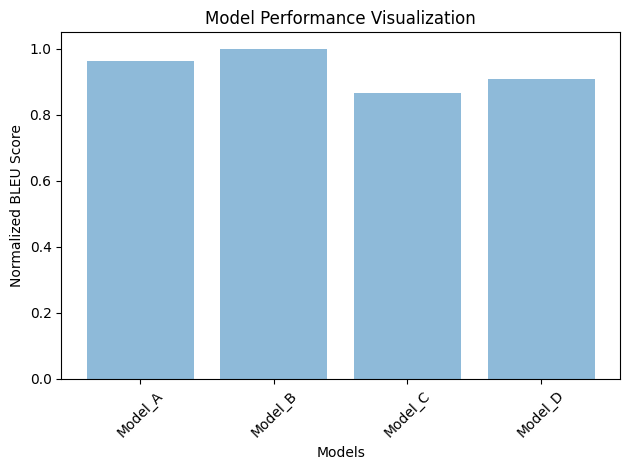

In [71]:
import matplotlib.pyplot as plt
import numpy as np

variables = ['Model_A', 'Model_B', 'Model_C', 'Model_D']
values = [trimmed_mean_A, trimmed_mean_B, trimmed_mean_C, trimmed_mean_D]

max_score = max(values)
normalized_values = [v / max_score for v in values]

# Plot
fig, ax = plt.subplots()

x_pos = np.arange(len(variables))

ax.bar(x_pos, normalized_values, align='center', alpha=0.5)

#x-axis ticks and labels
ax.set_xticks(x_pos)
ax.set_xticklabels(variables, rotation=45)

ax.set_xlabel('Models')
ax.set_ylabel('Normalized BLEU Score')
ax.set_title('Model Performance Visualization')

plt.tight_layout()
plt.show()